## This notebook looks to read an image and bound the ID. The bounded ID is padded, thresholded and cleaned. 

In [13]:
from google.cloud import vision
import os

import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import rotate
from skimage.draw import polygon

from helpers.corrections import *
from helpers.image_loading import * 
from helpers.handling import *
from helpers.identity_isolation import * 

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"../guppies-test-4c48569421d8.json"
client = vision.ImageAnnotatorClient()

In [2]:
random_files = ListAvaliableFiles('guppy_images', prefix='Manually_Labelled/New', verbose=False)
np.random.shuffle(random_files)

In [16]:
def GetImageAndParaBox(image_in_bytes, client, verbose=False):
    # Takes the whole image and returns the initially read output string, an image which contains 
    # the label (either cropped or whole), and the boxes around each of the charaters in the identity.
    whole_image = image_in_bytes

    img_byte_array = CroppedImage(whole_image, verbose=False)

    decoded = np.frombuffer(img_byte_array.getvalue(), dtype=np.uint8)
    frame = cv2.imdecode(decoded, cv2.IMREAD_COLOR) 

    content = img_byte_array.getvalue()
    image = vision.Image(content=content)

    response = client.document_text_detection(image=image, image_context={"language_hints": ["en"]})

    characters = []
    character_params = []
    character_heights = [] 

    output_string = ''
    word_confidences = []

    for a, page in enumerate(response.full_text_annotation.pages):
        for b, block in enumerate(page.blocks):
            for c, paragraph in enumerate(block.paragraphs):
                for d, word in enumerate(paragraph.words):
                    word_text = "".join([symbol.text for symbol in word.symbols])

                    if '-' in word_text:
                        """Sometimes dates are written with'-', not '/'. This line 
                        should short this out and replace the '-' before they 
                        get passed to the output string"""
                        if verbose: print('Replaced "-" in text with "/".')
                        word_text = word_text.replace('-', '/')
                    
                    output_string += '%s-' %word_text
                    word_confidences.append(word.confidence)
                    
                    for e, symbol in enumerate(word.symbols):

                        # Save character details
                        characters.append(symbol.text)
                        character_params.append([a, b, c, d, e])
                        if verbose: print(characters[-1], 'pageno:'+str(a), 'blockno:'+str(b), 'paragraphno:'+str(c), 'wordno:'+str(d), 'symbolno:'+str(e))

                        # Save the height of each character.
                        vertices = extract_vertices(symbol.bounding_box)
                        X = []
                        Y = []

                        for vertex in vertices:
                            X.append(vertex[0])
                            Y.append(vertex[1])
                            
                        X = np.array(X)
                        Y = np.array(Y)

                        character_heights.append(min(Y))
                        if verbose: print('character:', symbol.text, 'upper height:', max(Y), 'lower height:', min(Y))

    output_string = output_string.upper()
    if verbose: print('\nInitial label:', output_string[:-1].upper(), "\nConfidence:", np.prod(word_confidences))

    character_params = np.array(character_params)

    # If we have not read enough characters, the label may be moved outside the cropping box. Resort to reading the whole image and repeat above.
    if len(characters) < 7:
        if verbose: print('\nNot enough characters in ID, running with the whole image.')

        client = vision.ImageAnnotatorClient()
        content = whole_image.getvalue()
        image = vision.Image(content=content)
        response = client.document_text_detection(image=image, image_context={"language_hints": ["en"]})

        decoded = np.frombuffer(whole_image.getvalue(), dtype=np.uint8)
        frame = cv2.imdecode(decoded, cv2.IMREAD_COLOR) 

        characters = []
        character_params = []
        character_heights = [] 

        output_string = ''
        word_confidences = []

        for a, page in enumerate(response.full_text_annotation.pages):
            for b, block in enumerate(page.blocks):
                for c, paragraph in enumerate(block.paragraphs):
                    for d, word in enumerate(paragraph.words):

                        word_text = "".join([symbol.text for symbol in word.symbols])

                        if '-' in word_text:
                            """Sometimes dates are written with'-', not '/'. This line 
                            should short this out and replace the '-' before they 
                            get passed to the output string"""
                            if verbose: print('Replaced "-" in text with "/".')
                            word_text = word_text.replace('-', '/')
                        
                        output_string += '%s-' %word_text
                        word_confidences.append(word.confidence)

                        for e, symbol in enumerate(word.symbols):

                            # Save character details
                            characters.append(symbol.text)
                            character_params.append([a, b, c, d, e])
                            if verbose: print(characters[-1], 'pageno:'+str(a), 'blockno:'+str(b), 'paragraphno:'+str(c), 'wordno:'+str(d), 'symbolno:'+str(e))

                            # Save the height of each character.
                            vertices = extract_vertices(symbol.bounding_box)
                            X = []
                            Y = []

                            for vertex in vertices:
                                X.append(vertex[0])
                                Y.append(vertex[1])

                            X = np.array(X)
                            Y = np.array(Y)

                            character_heights.append(min(Y))
                            if verbose: print('character:', symbol.text, 'upper height:', max(Y), 'lower height:', min(Y))

        character_params = np.array(character_params)

    # If M or F are in the list of characters, remove everything before M or F.
    if 'M' in characters or 'F' in characters:
        lead_character = characters[0]
        while lead_character != 'F' and lead_character != 'M':

            if verbose: print('\nRemoving everything before F and M')
            if verbose: print('removing character', characters[0])

            characters = characters[1:]
            character_params = character_params[1:]
            character_heights = character_heights[1:]
            lead_character = characters[0]

            if verbose: print('Reduced characters are now:', characters)
            if verbose: print('Lead character is now:', lead_character)

            # If we drop below 7 characters then end.
            if len(characters) < 7:
                if verbose: print("Not enough characters to continue. Breaking the cycle.")
                return 1

    # Removing the three title characters:
    if verbose: print('Removing the title characters')
    title = characters[:3]
    characters = characters[3:]
    character_params = character_params[3:]
    character_heights = character_heights[3:]
    if verbose: print('Remaining characters are:', characters)

    # Remove any trailing *'s, x's or #'s
    if characters[0] == '*' or characters[0] == 'x' or characters[0] == 'X' or characters[0] == '#':
        characters = characters[1:]
        character_params = character_params[1:]
        character_heights = character_heights[1:]
        if verbose: print('Removing special character after title.')

    # Remove the date and everything after
    if verbose: print('Removing date and characters after date')
    date_index = np.argmax(['/' in i for i in characters])
    if verbose: print('date index is', date_index)
    
    if date_index == 0:
        if verbose: print("No '/' characters, searching for '-'")
        date_index = np.argmax(['-' in i for i in characters])
        if date_index == 0:
            if verbose: print("No '-' characters either. Cannot find date. Skipping step.")
            pass
        
    # Figure out if date is in the mm/dd/yy format or m/dd/yy format 
    # (how many numbers are in the first stage of the date).
    # Can't check for date starting '0' since 'O' can be the final letter of the
    # ID and is often confused for '0'
    if characters[date_index - 2] == '1':
        characters = characters[:date_index - 2]
        character_params = character_params[:date_index - 2]
        character_heights = character_heights[:date_index - 2]
        if verbose: 
            print('Remaining characters are:', characters)
            print('Ramaining character heights:', character_heights)
    
    else:
        characters = characters[:date_index - 1]
        character_params = character_params[:date_index - 1]
        character_heights = character_heights[:date_index - 1]
        if verbose: 
            print('Remaining characters are:', characters)
            print('Ramaining character heights:', character_heights)

    if len(characters) < 3:
        if verbose: print("Not enough characters to continue. Breaking the cycle.")
        return 1, 1, 1

    # Character in the [-2] position of height.
    ordered_height = np.argsort(character_heights)
    if verbose: print('Character heights are:', character_heights)
    if verbose: print('Character height order is:', ordered_height)
    # focused_index = ordered_height[5]
    focused_index = -2
    if verbose: print('Character and height in position 3 is:', characters[focused_index], character_heights[focused_index])

    # 3rd character bounding box is:
    focused_height = character_heights[focused_index]
    if verbose: print('character height is:', focused_height)

    # Cycle through and find include all characters with similar height
    ID_indices = []
    for i, character_height in enumerate(character_heights):
        if focused_height >= 0:
            if (focused_height - (focused_height * 0.09) ) <= character_height <= (focused_height + (focused_height * 0.09) ):
                ID_indices.append(i)
                if verbose: print('Character', characters[i], 'falls within height bounds')
        else:
            if (focused_height + (focused_height * 0.09) ) <= character_height <= (focused_height - (focused_height * 0.09) ):
                ID_indices.append(i)
                if verbose: print('Character', characters[i], 'falls within height bounds')

    # Remove any that are too far away from the central indicies (removes and stray date characters included)
    indices_diff = np.diff(ID_indices)
    for i, diff in enumerate(indices_diff):
        if diff > 3:
            if verbose: print('Removed %s as too far away from central indices' %characters[ID_indices[i+1]])
            ID_indices = ID_indices[:i + 1]

    # If less than 4 characters in the ID, then manually add more.
    remaining_character_length = len(characters)
    if remaining_character_length > 3:
        while len(ID_indices) < 4:
            if np.min(np.array(ID_indices)) == 0:
                also_include_index = np.max(np.array(ID_indices)) + 1
            else:
                also_include_index = np.min(np.array(ID_indices)) - 1
            ID_indices.insert(0, np.array(also_include_index))
            if verbose: print('Less than 4 chracters in ID. Adding', characters[also_include_index])

    elif remaining_character_length == 3:
        while len(ID_indices) < 3:
            if np.min(np.array(ID_indices)) == 0:
                also_include_index = np.max(np.array(ID_indices)) + 1
            else:
                also_include_index = np.min(np.array(ID_indices)) - 1
            ID_indices.insert(0, np.array(also_include_index))
            if verbose: print('Less than 3 chracters in ID. Adding', characters[also_include_index])

    else:
        return 1, 1, 1

    ID_characters = []
    ID_character_params = []
    ID_vertices = []
    
    for index in ID_indices:
        try:
            character = characters[index]
            character_param = character_params[index]
            page_no, block_no, paragraph_no, word_no, symbol_no = character_param
            character_bounds = extract_vertices(page.blocks[block_no].paragraphs[paragraph_no].words[word_no].symbols[symbol_no].bounding_box)

            ID_characters.append(character)
            ID_character_params.append(character_param)
            ID_vertices.append(extract_vertices(page.blocks[block_no].paragraphs[paragraph_no].words[word_no].symbols[symbol_no].bounding_box))
        except: pass

    if verbose: print('Included characters and their indicies are:', ID_characters, ID_indices)

    if ID_characters.count('/') > 1:
        if verbose: print('More than one "/" in ID_characters. Chances are, the date\
            has been identified. Returning "1"')
        return 1

    if verbose: print('Number of bounding boxes', len(ID_vertices))

    character_boxes = np.array(ID_vertices)

    if verbose: plt.imshow(frame)

    return output_string[:-1], frame, character_boxes

F pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:0
character: F upper height: 512 lower height: 406
T pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:1
character: T upper height: 512 lower height: 406
Y pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:2
character: Y upper height: 512 lower height: 406
6 pageno:0 blockno:1 paragraphno:0 wordno:0 symbolno:0
character: 6 upper height: 847 lower height: 736
/ pageno:0 blockno:1 paragraphno:0 wordno:0 symbolno:1
character: / upper height: 847 lower height: 736
2 pageno:0 blockno:1 paragraphno:0 wordno:0 symbolno:2
character: 2 upper height: 847 lower height: 736
1 pageno:0 blockno:1 paragraphno:0 wordno:0 symbolno:3
character: 1 upper height: 847 lower height: 736
/ pageno:0 blockno:1 paragraphno:0 wordno:0 symbolno:4
character: / upper height: 848 lower height: 737
1 pageno:0 blockno:1 paragraphno:0 wordno:0 symbolno:5
character: 1 upper height: 848 lower height: 737
1 pageno:0 blockno:1 paragraphno:0 wordno:0 symbolno:6
character

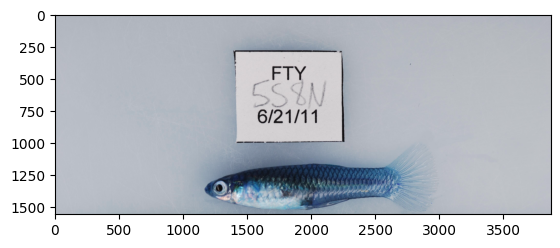

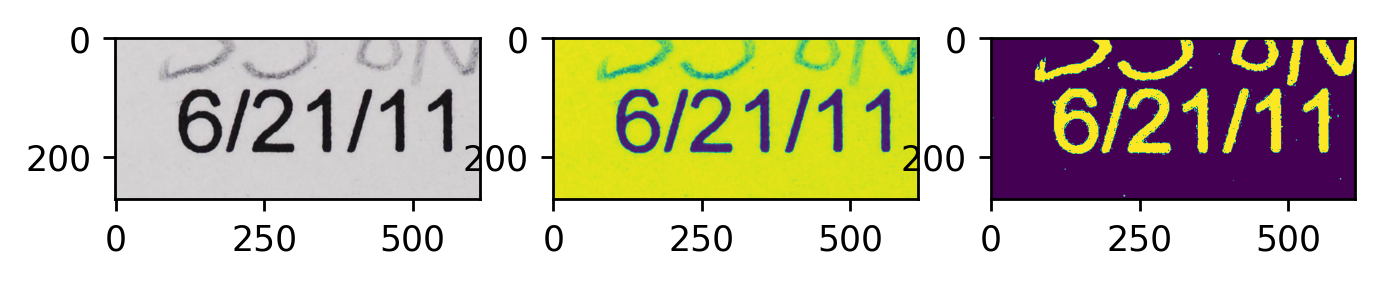

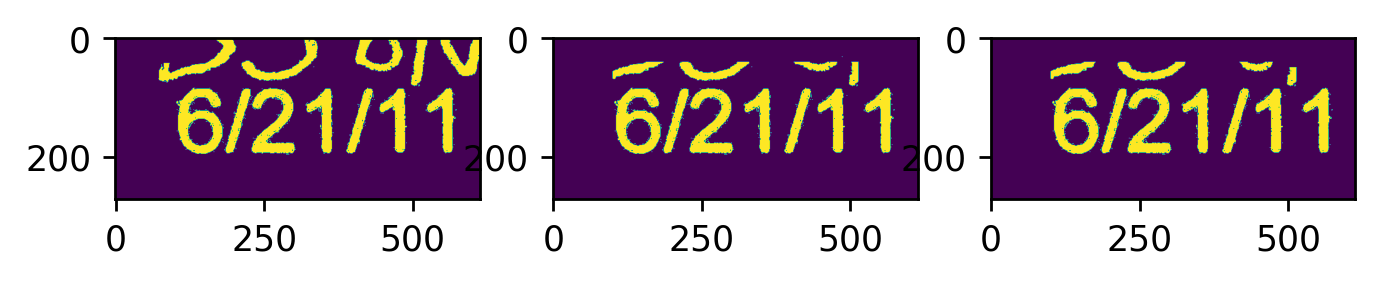

In [17]:
# Collect image from bucket
image_in_bytes = RetreiveImage(random_files[13])

# Read image and return initial output, frame and identity character boxes
output_string, frame, character_boxes = GetImageAndParaBox(image_in_bytes, client, verbose=True)

# Collect character boxes into a singe ID box.
identity_box = combine_boxes(character_boxes)

padx = 100
pady = 80
# Reduce the image to just the ID
reduced_frame = reduce_image(frame, identity_box, padx=padx, pady=pady)

# Mask and remove for final image
masked_image = mask_and_remove(reduced_frame, verbose = True)

# Remove deltas
final_image = remove_deltas(masked_image, width=15, padx=padx, pady=pady//2, verbose = True)

print(output_string)

Manually_Labelled/New/UL1112/FUL3B5O1112 (1).JPG


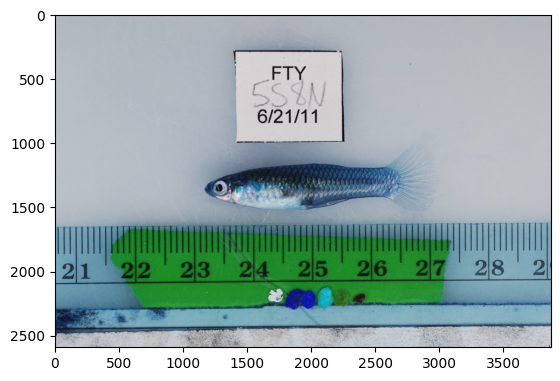

In [4]:
decoded = np.frombuffer(image_in_bytes.getvalue(), dtype=np.uint8)
frame = cv2.imdecode(decoded, cv2.IMREAD_COLOR) 
plt.imshow(frame)
print(random_files[8])

(upper thresh, lower_thresh) = (201.89, 14.00)


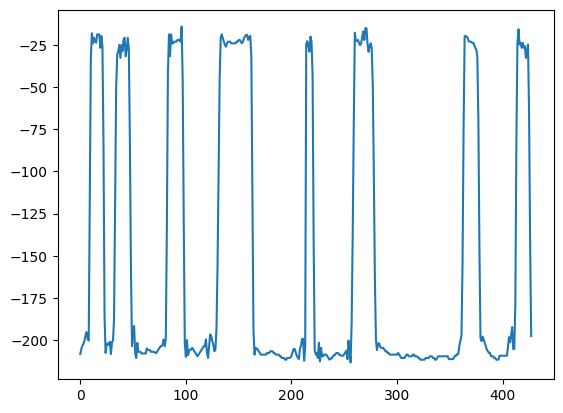

In [5]:
# Average out the RGB axis
averaged_frame = np.mean(reduced_frame,axis=2)

# White background masking
hist = np.histogram(averaged_frame, bins=100)
centers = 0.5*(hist[1][1:]+ hist[1][:-1])

thresh_val = np.argmax(hist[0] > np.max(hist[0]) * 0.2)
upper_thresh = centers[thresh_val] * 0.975

# Dark writing masking. Mask based on central row of frame
frame_shape = np.shape(averaged_frame)
row1 = -averaged_frame[2 * frame_shape[0] // 5][200:-200]
row2 = -averaged_frame[3 * frame_shape[0] // 5][200:-200]
rows = np.concatenate((row1, row2))
# rows = row2 = -averaged_frame[1]
row_mean = np.mean(rows)
row_max = np.max(rows)
row_min = np.min(rows)
peaks,_ = scipy.signal.find_peaks(rows, height = row_mean + ((row_max - row_min) / 5), distance=4)

values = []
for peak in peaks:
    values.append(-rows[peak])

sorted_values = np.sort(values)

lower_thresh = sorted_values[0] * 1

averaged_frame[averaged_frame>upper_thresh] = 0
averaged_frame[averaged_frame<lower_thresh] = 0
averaged_frame[averaged_frame!=0] = 255

plt.plot(rows)
# plt.imshow(averaged_frame)
print('(upper thresh, lower_thresh) = (%.2f, %.2f)' %(upper_thresh, lower_thresh))

205.67516666666666

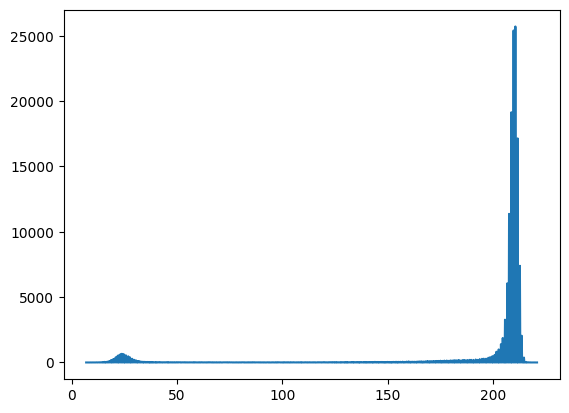

In [6]:
averaged_frame = np.mean(reduced_frame,axis=2)
hist = np.histogram(averaged_frame, bins=1000)
centers = 0.5*(hist[1][1:]+ hist[1][:-1])
plt.plot(centers, hist[0])

thresh = np.argmax(hist[0] > np.max(hist[0]) * 0.1)
centers[thresh]

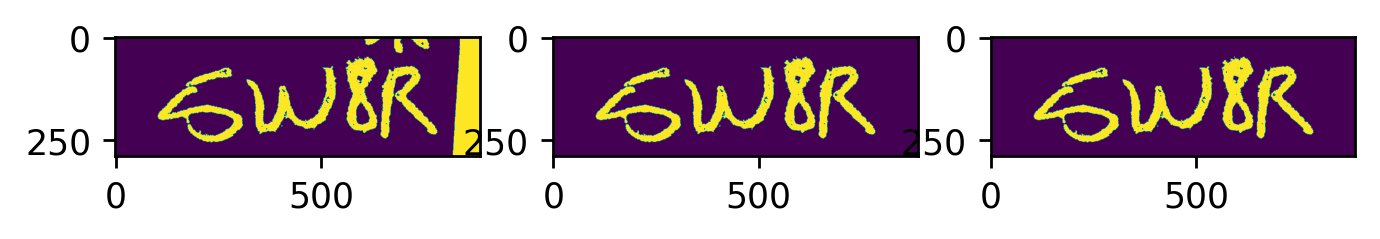

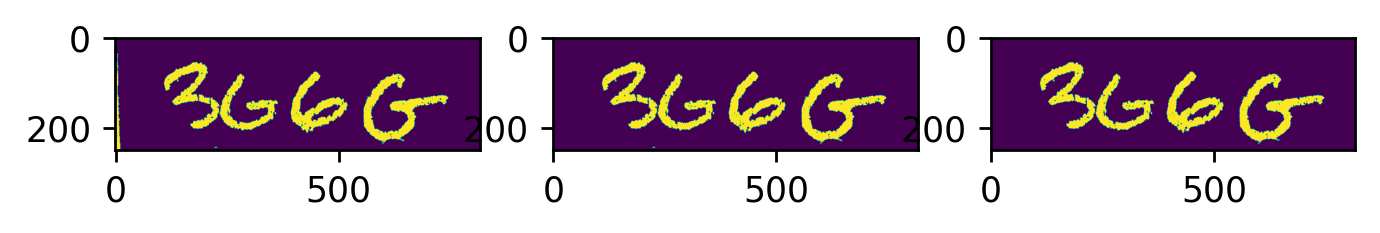

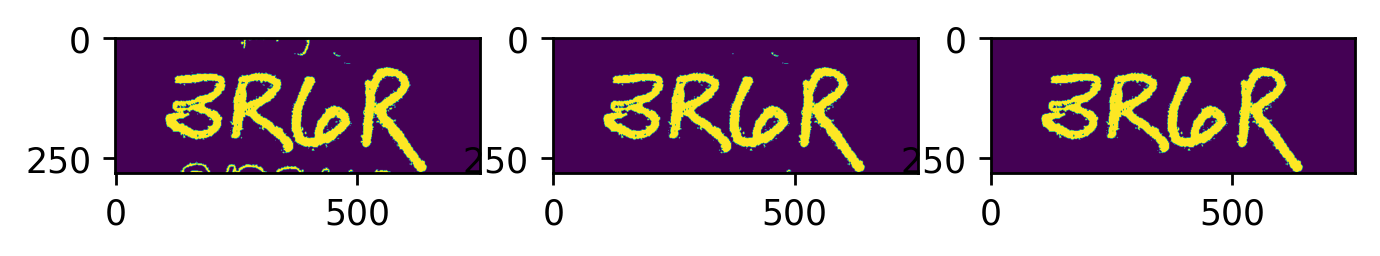

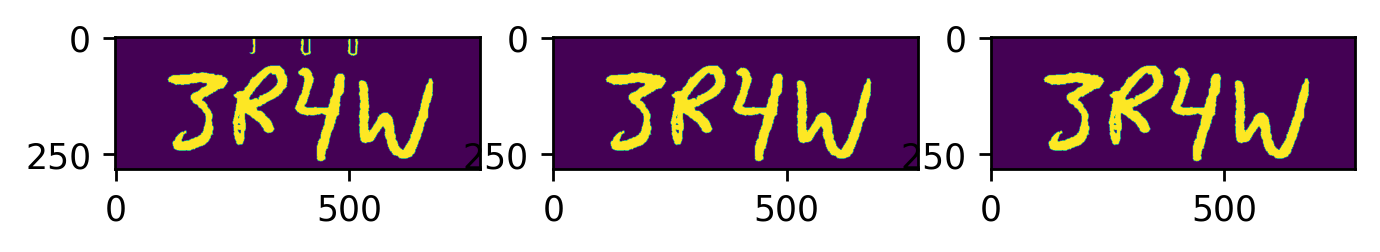

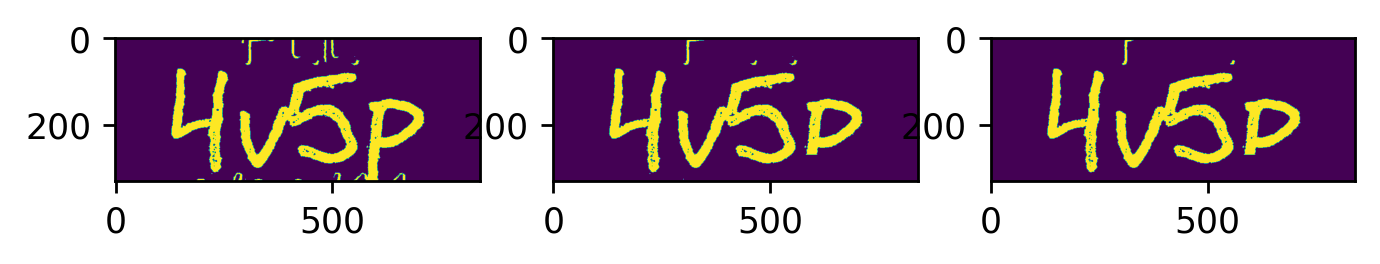

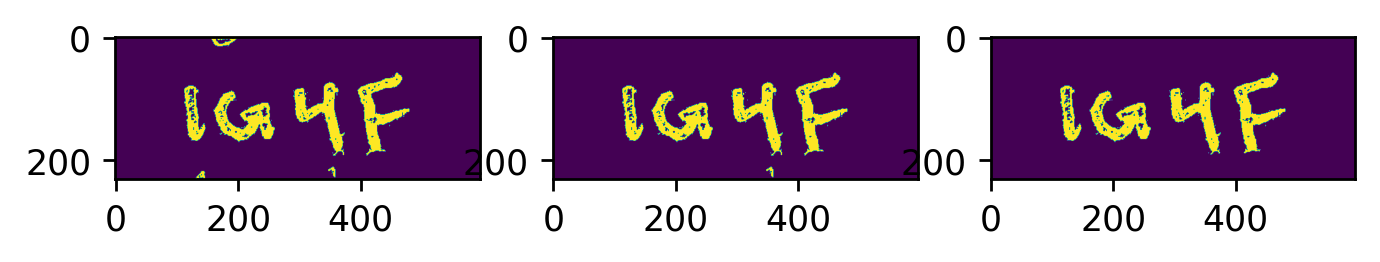

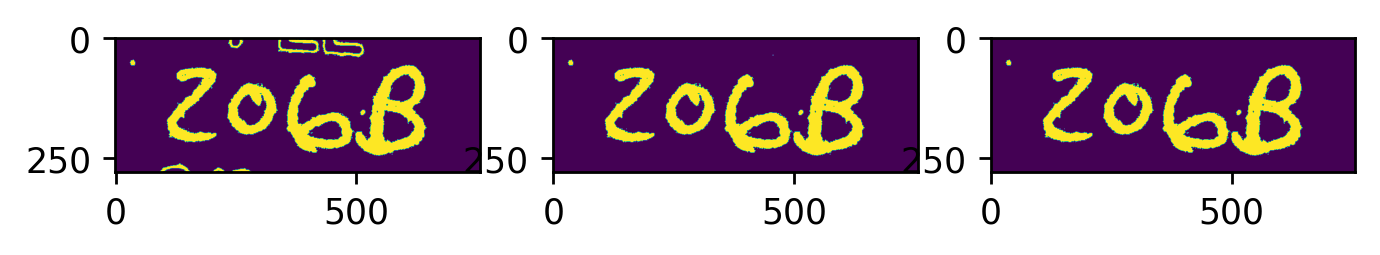

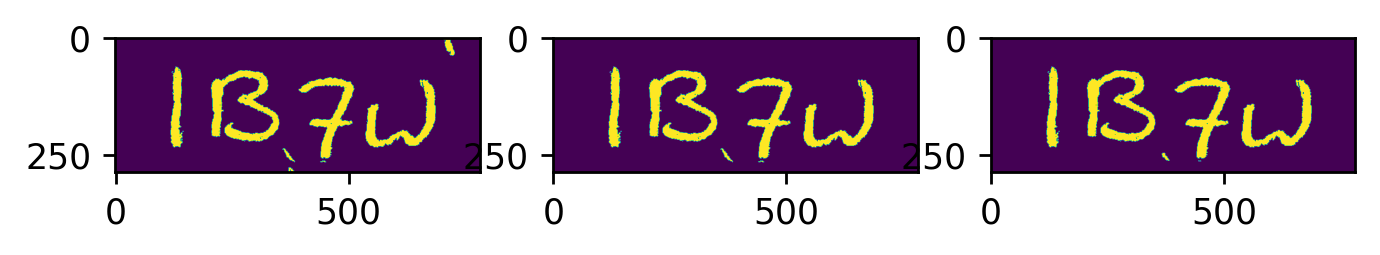

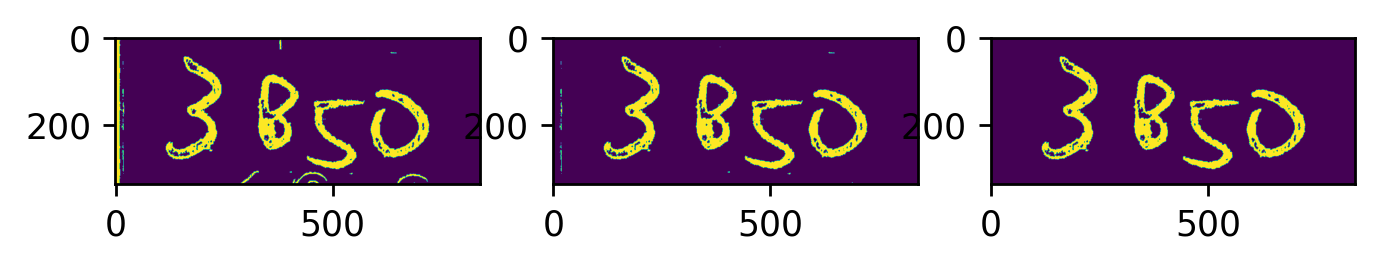

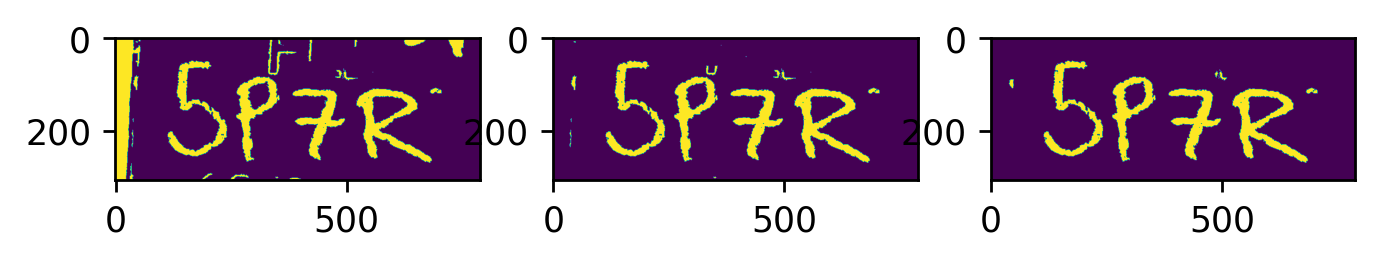

In [7]:
%matplotlib inline
padx = 100
pady = 60
for i in range(10):
    try:
        # Collect image from bucket
        image_in_bytes = RetreiveImage(random_files[i])

        # Read image and return initial output, frame and identity character boxes
        output_string, frame, character_boxes = GetImageAndParaBox(image_in_bytes, client, verbose=False)

        # Collect character boxes into a singe ID box.
        identity_box = combine_boxes(character_boxes)

        # Reduce the image to just the ID
        reduced_frame = reduce_image(frame, identity_box, padx=padx, pady=pady)

        # Mask and remove for final image
        masked_image = mask_and_remove(reduced_frame, verbose = False)

        # Remove deltas
        final_image = remove_deltas(masked_image, width=10, padx=padx, pady=pady, verbose = True)
    
    except:
        pass

M pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:0
character: M upper height: 359 lower height: 251
T pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:1
character: T upper height: 356 lower height: 248
Y pageno:0 blockno:0 paragraphno:0 wordno:0 symbolno:2
character: Y upper height: 355 lower height: 247
1 pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:0
character: 1 upper height: 536 lower height: 420
W pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:1
character: W upper height: 534 lower height: 417
3 pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:2
character: 3 upper height: 531 lower height: 414
P pageno:0 blockno:0 paragraphno:0 wordno:1 symbolno:3
character: P upper height: 529 lower height: 412
7 pageno:0 blockno:0 paragraphno:0 wordno:2 symbolno:0
character: 7 upper height: 694 lower height: 581
/ pageno:0 blockno:0 paragraphno:0 wordno:2 symbolno:1
character: / upper height: 693 lower height: 581
2 pageno:0 blockno:0 paragraphno:0 wordno:2 symbolno:2
character

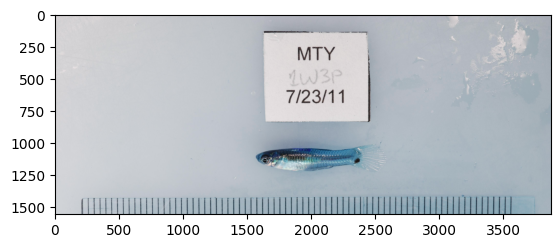

In [8]:
# Collect image from bucket
image_in_bytes = RetreiveImage(random_files[102])

# Read image and return initial output, frame and identity character boxes
output_string, frame, character_boxes = GetImageAndParaBox(image_in_bytes, client, verbose=True)

# Collect character boxes into a singe ID box.
identity_box = combine_boxes(character_boxes)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


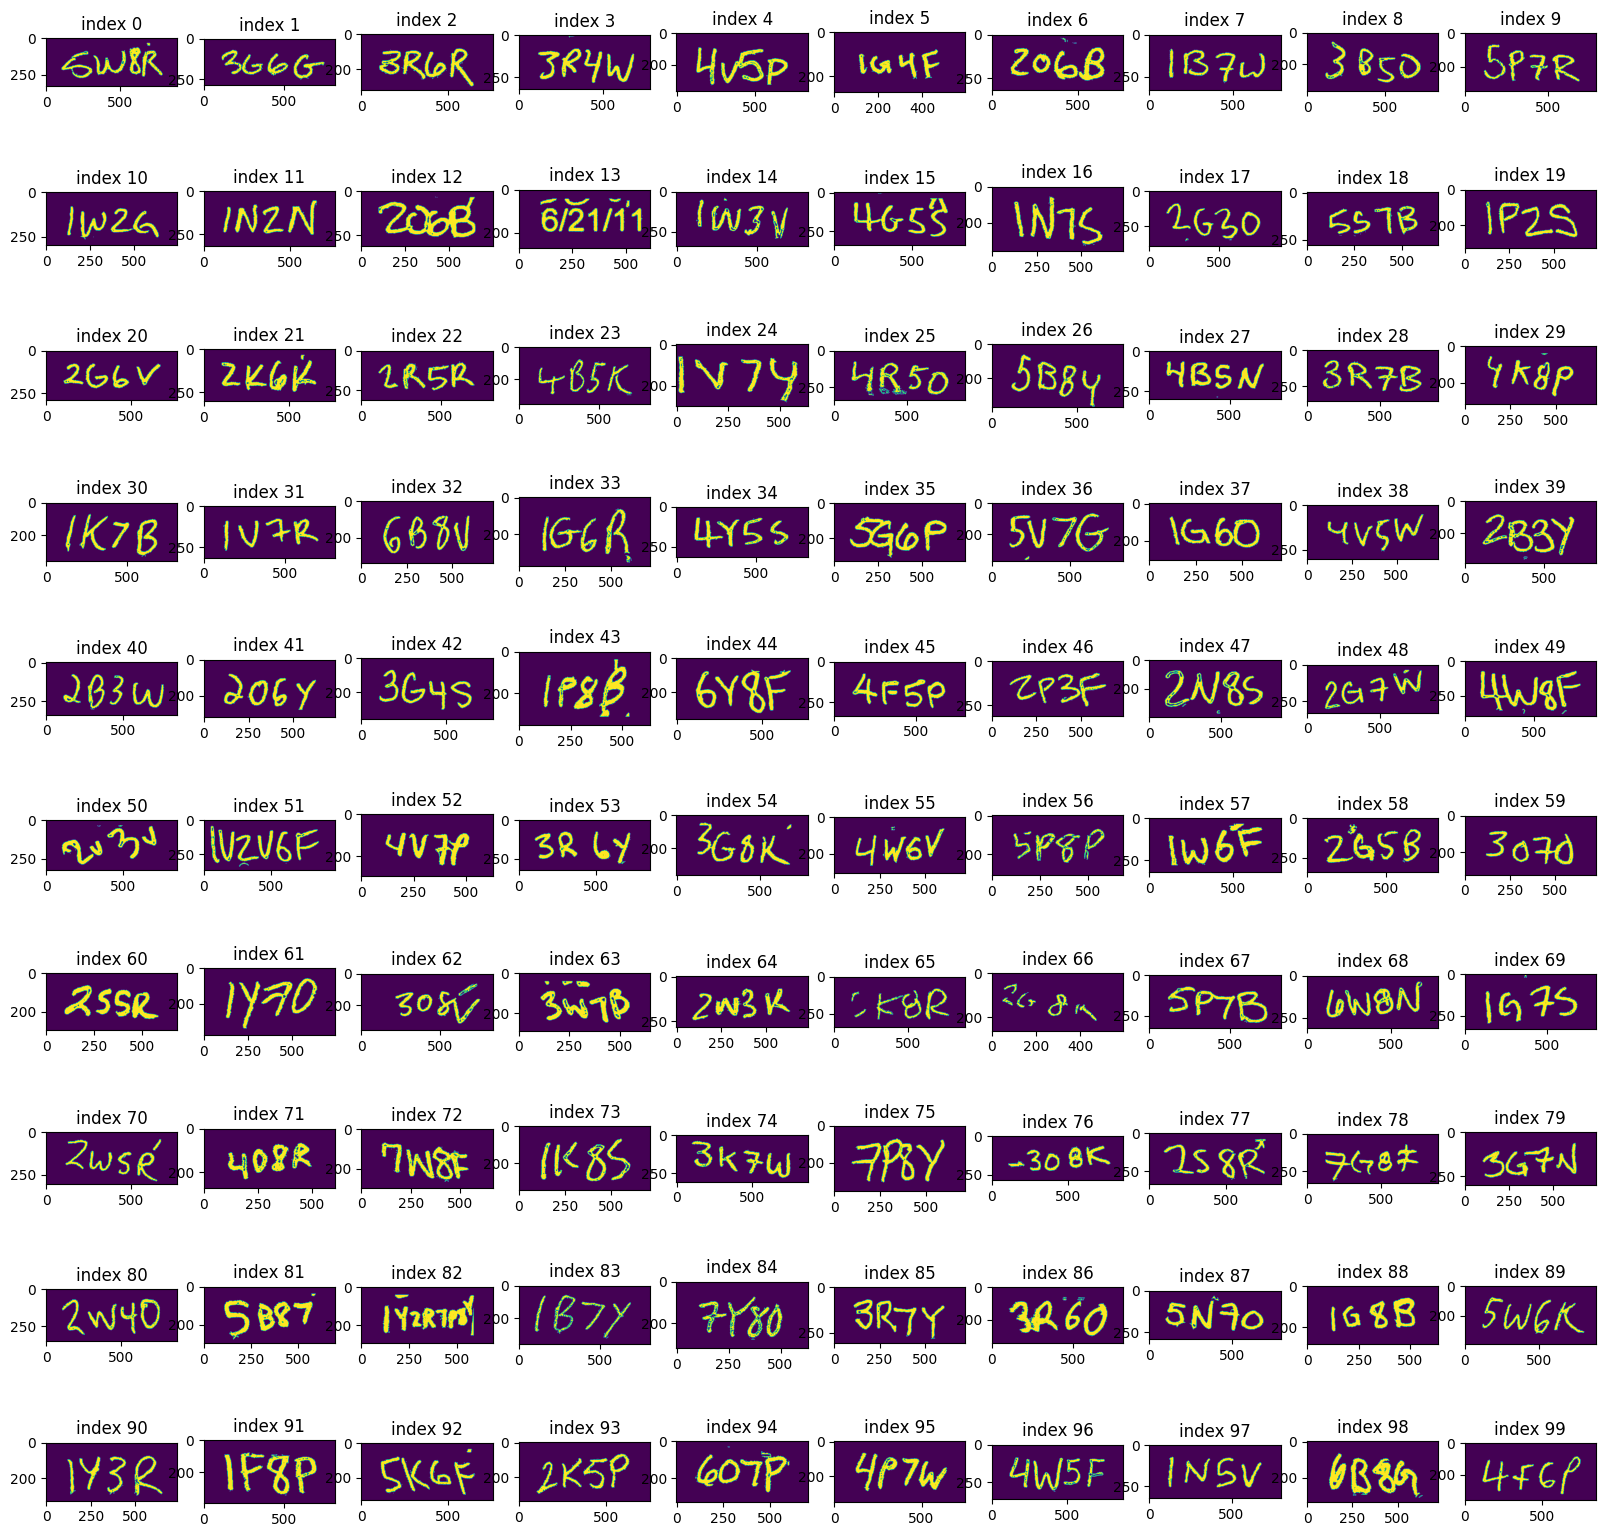

In [11]:
client = vision.ImageAnnotatorClient()
fig,ax = plt.subplots(10,10, figsize=(20,20))
padx = 100
pady = 80

i = 0
j = 0

while i < 100:
    try:
        # Collect image from bucket
        image_in_bytes = RetreiveImage(random_files[j])

        # Read image and return initial output, frame and identity character boxes
        output_string, frame, character_boxes = GetImageAndParaBox(image_in_bytes, client, verbose=False)

        # Collect character boxes into a singe ID box.
        identity_box = combine_boxes(character_boxes)

        # Reduce the image to just the ID
        reduced_frame = reduce_image(frame, identity_box, padx=padx, pady=pady)

        # Mask and remove for final image
        masked_image = mask_and_remove(reduced_frame, verbose = False)

        # Remove deltas
        final_image = remove_deltas(masked_image, width=15, padx=padx, pady=pady//2, verbose = False)

        ax[i // 10, i % 10].imshow(final_image)
        ax[i // 10, i % 10].set_title('index %i' %j)

        i += 1
        j += 1
        print(j)
    except:
        j += 1
        pass

In [15]:
lst = ['/', '2', '3', '/', '2', '3']
lst.count('/')

2